In [2]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from doubleml.datasets import make_plr_CCDDHNR2018
import doubleml as dml
from flaml import AutoML
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Generate synthetic data
data = make_plr_CCDDHNR2018(alpha=0.5, n_obs=1000, dim_x=50, return_type="DataFrame")

# Initialize AutoML for outcome model (ml_l)
automl_l = AutoML()
settings_l = {
    "time_budget": 120,
    "metric": 'rmse',
    "estimator_list": ['xgboost'],
    "task": 'regression',
}
automl_l.fit(X_train=data.drop(columns=["y", "d"]).values, y_train=data["y"].values, verbose=2, **settings_l)

# Initialize AutoML for treatment model (ml_m)
automl_m = AutoML()
settings_m = {
    "time_budget": 120,
    "metric": 'rmse',
    "estimator_list": ['xgboost'],
    "task": 'regression',
}
automl_m.fit(X_train=data.drop(columns=["y", "d"]).values, y_train=data["d"].values, verbose=2, **settings_m)

# Check for Overfitting: Compare in-sample (train), out-of-sample (test) MSE
# ml_m
rmse_oos_ml_m = automl_m.best_loss
rmse_oos_ml_l = automl_l.best_loss

# Create DoubleMLData object with the evaluation set
obj_dml_data = dml.DoubleMLData(data, "y", "d")

# Initialize DoubleMLPLR with the trained models from flaml
obj_dml_plr = dml.DoubleMLPLR(obj_dml_data, ml_m=automl_m.model.estimator, ml_l=automl_l.model.estimator)

# Fit the DoubleMLPLR model
obj_dml_plr.fit()

# Evaluate learners using evaluate_learners() (MSE for all nuisance components)
rmse_ins_ml_l = obj_dml_plr.evaluate_learners()['ml_l'][0]
rmse_ins_ml_m = obj_dml_plr.evaluate_learners()['ml_m'][0]

# Print results
print("Tuning RMSE (ml_m):", rmse_ins_ml_m)
print("Evaluation RMSE (ml_m):", rmse_oos_ml_m)
print("Tuning RMSE (ml_l):", rmse_ins_ml_l)
print("Evaluation RMSE (ml_l):", rmse_oos_ml_l)

Tuning RMSE (ml_m): [1.03274461]
Evaluation RMSE (ml_m): 1.0271747767073314
Tuning RMSE (ml_l): [1.08927038]
Evaluation RMSE (ml_l): 1.0837776193821544


### Replacing FLAML tuning with FLAML Classifier and Regressor 

In [4]:
from flaml import AutoML
from sklearn.utils.multiclass import unique_labels

class FlamlRegressorDoubleML:
    _estimator_type = 'regressor'

    def __init__(self, time, estimator_list, metric, *args, **kwargs):
        self.auto_ml = AutoML(*args, **kwargs)
        self.time = time
        self.estimator_list = estimator_list
        self.metric = metric

    def set_params(self, **params):
        self.auto_ml.set_params(**params)
        return self

    def get_params(self, deep=True):
        dict = self.auto_ml.get_params(deep)
        dict["time"] = self.time
        dict["estimator_list"] = self.estimator_list
        dict["metric"] = self.metric
        return dict

    def fit(self, X, y):
        self.auto_ml.fit(X, y, task="regression", time_budget=self.time, estimator_list=self.estimator_list, metric=self.metric, verbose=False)
        self.tuned_model = self.auto_ml.model.estimator
        return self

    def predict(self, x):
        preds = self.tuned_model.predict(x)
        return preds
        
class FlamlClassifierDoubleML:
    _estimator_type = 'classifier'

    def __init__(self, time, estimator_list, metric, *args, **kwargs):
        self.auto_ml = AutoML(*args, **kwargs)
        self.time = time
        self.estimator_list = estimator_list
        self.metric = metric

    def set_params(self, **params):
        self.auto_ml.set_params(**params)
        return self

    def get_params(self, deep=True):
        dict = self.auto_ml.get_params(deep)
        dict["time"] = self.time
        dict["estimator_list"] = self.estimator_list
        dict["metric"] = self.metric
        return dict

    def fit(self, X, y):
        self.classes_ = unique_labels(y)
        self.auto_ml.fit(X, y, task="classification", time_budget=self.time, estimator_list=self.estimator_list, metric=self.metric, verbose=False)
        self.tuned_model = self.auto_ml.model.estimator
        return self

    def predict_proba(self, x):
        preds = self.tuned_model.predict_proba(x)
        return preds

In [5]:
# Define the FlamlRegressorDoubleML
ml_l = FlamlRegressorDoubleML(time=120, estimator_list=['xgboost'], metric='rmse')
ml_m = FlamlRegressorDoubleML(time=120, estimator_list=['xgboost'], metric='rmse')

# Create DoubleMLPLR object using the new regressors
dml_plr_obj_tuned = dml.DoubleMLPLR(obj_dml_data, ml_m, ml_l)

# Fit the DoubleMLPLR model
dml_plr_obj_tuned.fit(store_predictions=True)

# Print the summary
print(dml_plr_obj_tuned.summary)

       coef   std err          t         P>|t|     2.5 %    97.5 %
d  0.464399  0.029765  15.602241  7.028275e-55  0.406061  0.522738


Tuned Summary:
       coef   std err          t         P>|t|     2.5 %   97.5 %
d  0.464019  0.029818  15.561799  1.323263e-54  0.405577  0.52246
Untuned Summary:
       coef   std err         t          P>|t|     2.5 %    97.5 %
d  0.605325  0.023441  25.82346  4.835043e-147  0.559382  0.651268
Dummy Summary:
      coef   std err          t          P>|t|     2.5 %    97.5 %
d  0.67958  0.020288  33.496641  5.394302e-246  0.639816  0.719344
Extracted model labels: Index(['FLAML Tuned', 'AutoML Untuned', 'Dummy'], dtype='object', name='Model Type')
Extracted coefficient values: [0.46401856 0.60532514 0.67958017]


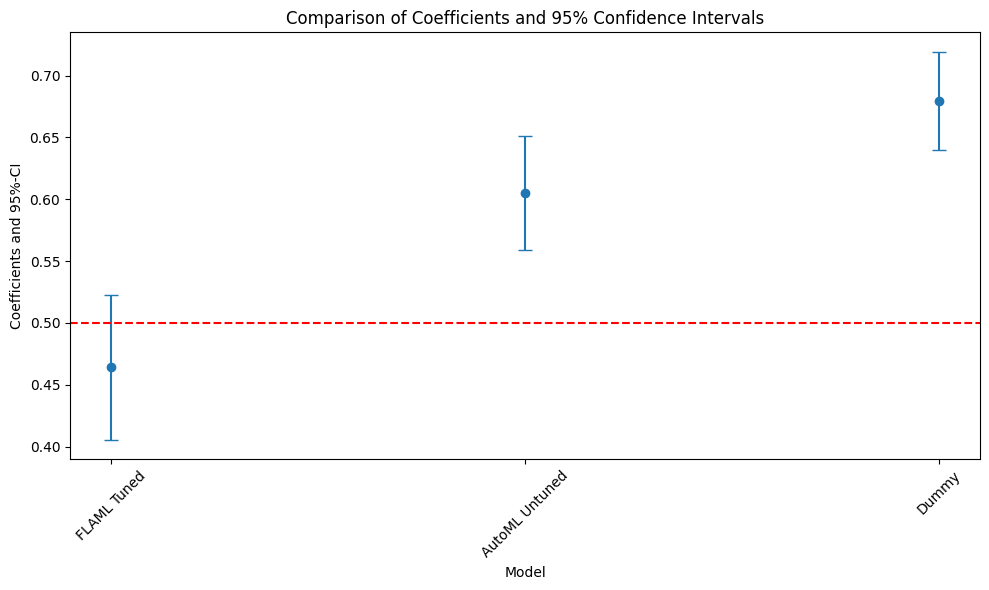

In [24]:
from sklearn.dummy import DummyRegressor
tuned_summary = dml_plr_obj_tuned.summary

# Initialize and fit dummy models
ml_l_dummy = DummyRegressor(strategy='mean')
ml_m_dummy = DummyRegressor(strategy='mean')

# Create DoubleMLPLR object using dummy regressors
dml_plr_obj_dummy = dml.DoubleMLPLR(obj_dml_data, ml_m_dummy, ml_l_dummy)
dml_plr_obj_dummy.fit(store_predictions=True)

# Retrieve the summary for dummy models
dummy_summary = dml_plr_obj_dummy.summary

# AutoML Untuned
automl_untuned_l = AutoML()
settings = {
    "time_budget": 0.01,
    "metric": 'mse',
    "estimator_list": ['xgboost'],
    "task": 'regression',
}

automl_untuned_l.fit(X_train=data.drop(columns=["y", "d"]).values, y_train=data["y"].values, verbose=0, **settings)

automl_untuned_m = AutoML()
settings = {
    "time_budget": 0.01,
    "metric": 'mse',
    "estimator_list": ['xgboost'],
    "task": 'regression',
}

automl_untuned_m.fit(X_train=data.drop(columns=["y", "d"]).values, y_train=data["d"].values, verbose=0, **settings)

# Create DoubleMLPLR object using AutoML models
dml_plr_obj_untuned_automl = dml.DoubleMLPLR(obj_dml_data, automl_untuned_l.model.estimator, automl_untuned_m.model.estimator)
untuned_automl_summary = dml_plr_obj_untuned_automl.fit(store_predictions=True).summary

# Combine summaries for comparison
summary = pd.concat([tuned_summary, untuned_automl_summary, dummy_summary], keys=['FLAML Tuned', 'AutoML Untuned', 'Dummy'])
summary.index.names = ['Model Type', 'Metric']

# Save the summary to a file
summary.to_pickle("summary_comparison.pkl")

# Check the structure of the summary DataFrames
print("Tuned Summary:")
print(tuned_summary.head())

print("Untuned Summary:")
print(untuned_automl_summary.head())

print("Dummy Summary:")
print(dummy_summary.head())

# Check if `summary` contains the required columns
required_columns = ['coef', '2.5 %', '97.5 %']
if not all(col in summary.columns for col in required_columns):
    raise ValueError("Summary DataFrame is missing required columns.")

# Extract model labels and coefficient values
model_labels = summary.index.get_level_values('Model Type')
coef_values = summary['coef'].values

print("Extracted model labels:", model_labels)
print("Extracted coefficient values:", coef_values)

# Calculate errors
errors = np.full((2, len(coef_values)), np.nan)
errors[0, :] = summary['coef'] - summary['2.5 %']
errors[1, :] = summary['97.5 %'] - summary['coef']

# Plot Coefficients and 95% Confidence Intervals
plt.figure(figsize=(10, 6))
plt.errorbar(model_labels, coef_values, fmt='o', yerr=errors, capsize=5)
plt.axhline(0.5, color='red', linestyle='--')
plt.xlabel('Model')
plt.ylabel('Coefficients and 95%-CI')
plt.title('Comparison of Coefficients and 95% Confidence Intervals')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

def print_scores(dml_obj, store_predictions=False):
    if store_predictions:
        dml_obj.fit(store_predictions=True)
    summary_df = dml_obj.summary
    print("Summary DataFrame columns:", summary_df.columns)
    print("Summary DataFrame index:", summary_df.index)
    
    # Extract available metrics from the index
    available_metrics = summary_df.index
    print("Available metrics:", available_metrics)
    
    # Select a metric to compare, e.g., 'd'
    metric_to_use = 'd'
    if metric_to_use not in available_metrics:
        raise KeyError(f"{metric_to_use} not found in summary.")
    
    scores = summary_df.loc[metric_to_use]
    return scores

# Calculate and store scores for comparison
scores = {
    "FLAML Tuned": print_scores(dml_plr_obj_tuned, True),
    "AutoML Untuned": print_scores(dml_plr_obj_untuned_automl, True),
    "Dummy": print_scores(dml_plr_obj_dummy, True)
}
scores_df = pd.DataFrame(scores)

# Save the scores to a file
scores_df.to_pickle("scores_comparison.pkl")

# Plot MSE scores
scores_df.plot(kind='bar', title='Comparison of Metrics for l_of_X and m_of_X')
plt.ylabel('Scores')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
print("Summary DataFrame:")
print(summary)

Summary DataFrame:
                         coef   std err          t          P>|t|     2.5 %  \
Model Type   Metric                                                           
FLAML Tuned  d       0.464399  0.029765  15.602241   7.028275e-55  0.406061   
Manual Tuned d       0.606239  0.023633  25.651964  4.019974e-145  0.559919   
Dummy        d       0.680642  0.020259  33.596561  1.883180e-247  0.640935   

                       97.5 %  
Model Type   Metric            
FLAML Tuned  d       0.522738  
Manual Tuned d       0.652559  
Dummy        d       0.720350  


In [23]:
print("Available rows in summary:")
print(dml_plr_obj_tuned.summary.index)

print("Available columns in summary:")
print(dml_plr_obj_tuned.summary.columns)

Available rows in summary:
Index(['d'], dtype='object')
Available columns in summary:
Index(['coef', 'std err', 't', 'P>|t|', '2.5 %', '97.5 %'], dtype='object')
